# Sentiment

Sentiment is one of the largest attractors of applied analysis - is this passage positive or negative? Is this person happy or unhappy? 

This seems like a daunting task, but in its most basic form it is relatively easy. 

# The basics of sentiment

Human's use of language will always have some implied emotion and decoding that increases its quantitative appeal. However, this mapping of word to sentiment (positive or negative, how positive or negative) must be done since it doesn't already exist in written or spoken language.

This mapping **must** be constructed. 

Different considerations are made by creators when they construct their dicionaries. If you are using a pre-built dictionary then you should spend time considering the match between the dictionary provenance and your dataset.

# AFINN

As a start, we will be using the AFINN sentiment dictionary (Finn Årup Nielsen, "A new ANEW: Evaluation of a word list for sentiment analysis in microblogs", http://arxiv.org/abs/1103.2903). The larger word list is AFINN 111

In [16]:
afinnlist = [l.strip().split('\t') for l in open('../data/AFINN/AFINN-111.txt').readlines()]
afinn = {k:int(v) for k,v in afinnlist}
list(afinn.items())[:5]

[('woeful', -3),
 ('drowns', -2),
 ('insult', -2),
 ('impose', -1),
 ('crisis', -3)]

And then we can do a basic test.

In [31]:
import nltk

example_text = "Adam is totally cool. You should come to his class"
for word in nltk.word_tokenize(example_text):
    if word in afinn:
        print(word, afinn[word])
    else:
        print(word, '-')

Adam -
is -
totally -
cool 1
. -
You -
should -
come -
to -
his -
class -


As we can see, only word assigned a sentiment score is "cool".

`Adam` is a proper noun, `You` is a pronoun, `his` is a possessive - so no sentiment there

`is`, `should`, and `come` are the verbs - so no sentiment

`to` is a preposition

`class` is a noun

`totally` is a different story though. It's an adverb and is modifying `cool`, which is positive. However, the sentiment of `totally` is entirely dependent on the word that it is modifying. So on its own, it it doesn't actually have a score.

So we can judge that this overall text is mildly positive, there isn't that much to go on though since it's such a small piece! 

There could be more that we could write to understand `totally` and it's relationship to `cool`, but we'll save that for later. Right now we're going to stick to analyzing unigrams (single words) as just a bag (which actually works really well as a first approximation!

I want to start with text that we already understand. So lets pull in Iago and Othello's text

In [33]:
iago_words = [l.strip() for l in open('../data/IAGO_nltk_words.txt').readlines()]
othello_words = [l.strip() for l in open('../data/OTHELLO_nltk_words.txt').readlines()]

['Ti',
 'better',
 'Let',
 'spite',
 'My',
 'servic',
 'I',
 'done',
 'signiori',
 'Shall']

Now remember, we saved the stemmed words and AFINN has full, unstemmed words. In order to find almost any words in AFINN we will need to stem the words in the dictionary.

In [34]:
#Exercise


In [35]:
#Answer
from nltk.stem import PorterStemmer
ps = PorterStemmer()

afinnstem = {}
for k,v in afinn.items():
    afinnstem[ps.stem(k)] = v

Now pull the sentiment for Iago and Othello's dialogue. How many words have a definition here?

In [36]:
#Exercise


In [45]:
#Answer
import numpy as np
def pull_sentiment(wordlist, store_not_found=False):
    sentiment = []
    for word in wordlist:
        if word.lower() in afinnstem:
            sentiment.append(afinnstem[word.lower()])
        else:
            if store_not_found == True:
                sentiment.append(np.nan)
    return sentiment

print('iago', len(pull_sentiment(iago_words)), len(iago_words))
print('othello', len(pull_sentiment(othello_words)), len(othello_words))

iago 765 5059
othello 667 4076


As you can see, a small fraction of the words have a sentiment coded in the dictionary. Some of this is due to the number of words carrying sentiment being smaller, while the other part is the mismatch in dictionary source to that of the target data.

Still we should examine what we have done so far here.

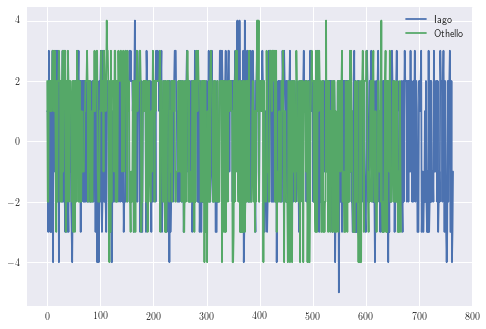

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.plot(pull_sentiment(iago_words), label='Iago')
plt.plot(pull_sentiment(othello_words), label='Othello')
plt.legend(loc='best')

Too noisy, ideally we would want to see a moving average. We can write one ourselves or we can use Pandas

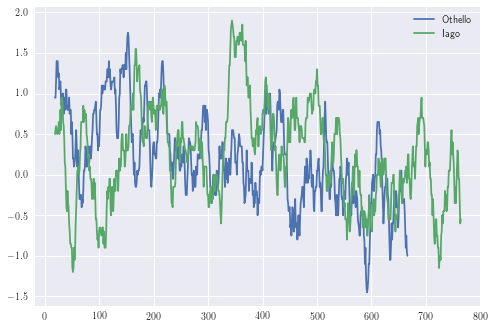

In [47]:
import pandas as pd
othello_running = pd.Series(pull_sentiment(othello_words)).rolling(window=20).mean()
iago_running = pd.Series(pull_sentiment(iago_words)).rolling(window=20).mean()

plt.plot(othello_running, label='Othello')
plt.plot(iago_running, label='Iago')
plt.legend(loc='best')

In an easier fashion, we could use this to assess the tone of Othello over time. Read in the entire play and plot the sentiment over time.

In [44]:
#Exercise


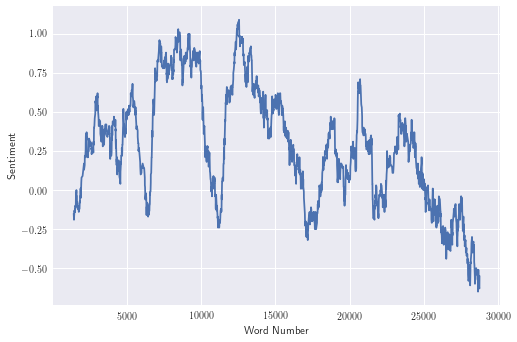

In [58]:
#Answer
nltk_regex = nltk.RegexpTokenizer('\w+')
full_play = [ps.stem(l.lower()) \
             for l in  nltk_regex.tokenize(open('../data/Othello.txt').read())]
full_sentiment = pull_sentiment(full_play, store_not_found=True)
full_rolling = pd.Series(full_sentiment).dropna().rolling(window=100).mean()
plt.plot(full_rolling)
plt.ylabel('Sentiment')
plt.xlabel('Word Number')

What are those dips?

In [63]:
#Exercise


In [73]:
#Answer
acts = {}
for i,words in enumerate(open('../data/Othello.txt').read().split('ACT ')[1:]):
    acts[i] = [ps.stem(l.lower()) for l in  nltk_regex.tokenize(words)]
acts_sentiment ={}
for i, words in acts.items():
    acts_sentiment[i] = pull_sentiment(words)
breaks = [0]
for i in range(5):
    breaks.append(len(acts_sentiment[i]) + breaks[i])
full_set = []
for i in range(5):
    full_set += acts_sentiment[i]
act_rolling = pd.Series(full_set).rolling(window=50).mean()

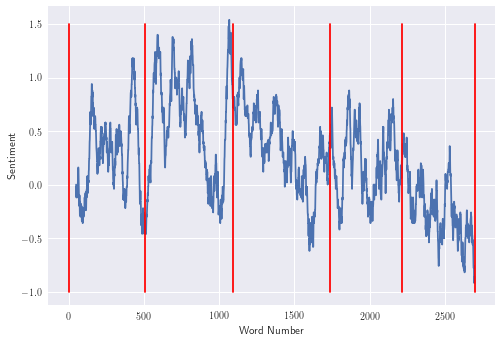

In [75]:
#Answer
plt.plot(act_rolling)
plt.ylabel('Sentiment')
plt.xlabel('Word Number')
for bnum in breaks:
    plt.plot([bnum, bnum], [-1, 1.5], color='r')

And now we can begin to 'visualize' what each act is like now through this simple analysis. Even though this sentiment dictionary is *very* mismatched to this dataset, it still works to deliver a coarse analysis/first approximation. One wouldn't publish with this data, but it would be a quick first pass that you could use to justify further effort in developing or purchasing a sentiment dictionary that was actually appropriate for the source text.

# Matching the dictionary to its purpose

Since the AFINN dataset is actually for 'microblogs', we will now switch to the nltk twitter dataset

In [23]:
import nltk
from nltk.corpus import twitter_samples

twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [27]:
twitter_samples.strings('tweets.20150430-223406.json')[:5]

['RT @KirkKus: Indirect cost of the UK being in the EU is estimated to be costing Britain £170 billion per year! #BetterOffOut #UKIP',
 'VIDEO: Sturgeon on post-election deals http://t.co/BTJwrpbmOY',
 'RT @LabourEoin: The economy was growing 3 times faster on the day David Cameron became Prime Minister than it is today.. #BBCqt http://t.co…',
 'RT @GregLauder: the UKIP east lothian candidate looks about 16 and still has an msn addy http://t.co/7eIU0c5Fm1',
 "RT @thesundaypeople: UKIP's housing spokesman rakes in £800k in housing benefit from migrants.  http://t.co/GVwb9Rcb4w http://t.co/c1AZxcLh…"]

As we can see, this corpus is composed of completely non-confrontational tweets surrounding the Brexit vote. Using the built-in tools we can pull these tweets out. To start with we will actually use the positive and negative tweets to test how well our dictionary matches the classification.

In [78]:
negtweets = [x for x in twitter_samples.tokenized('negative_tweets.json')]
postweets = [x for x in twitter_samples.tokenized('positive_tweets.json')]

And  now we can go through and evaluate each of these tweets

In [79]:
#Exercise


negative 2543 5000
positive 2622 5000


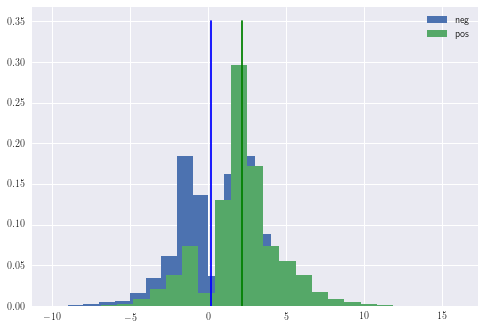

In [94]:
#Answer
neg_score_sets = [xset for xset in [pull_sentiment(x) for x in negtweets] if len(xset)!=0]
pos_score_sets = [xset for xset in [pull_sentiment(x) for x in postweets] if len(xset)!=0]
#Now we can see how many we dropped
print('negative', len(neg_score_sets), len(negtweets))
print('positive', len(pos_score_sets), len(postweets))

neg_scores = [sum(x) for x in neg_score_sets if len(x)!=0]
pos_scores = [sum(x) for x in pos_score_sets if len(x)!=0]

plt.hist(neg_scores, label='neg', normed=True, bins=25)
plt.hist(pos_scores, label='pos', normed=True, bins=25)
plt.plot([np.mean(neg_scores), np.mean(neg_scores)], [0, 0.35], color='b')
plt.plot([np.mean(pos_scores), np.mean(pos_scores)], [0, 0.35], color='g')
plt.legend(loc='best')

We can see a clear separation in the sum of tone used so long as we discard samples where no sentiment was found for any word there.

Of course, NLTK has tools built in to help with sentiment detection. One of the biggest questions is always, "how do I handle negation?"

In [101]:
from nltk.sentiment.util import mark_negation

sentence = "I didn't like this movie . It was bad".split()
mark_negation(sentence)

['I', "didn't", 'like_NEG', 'this_NEG', 'movie_NEG', '.', 'It', 'was', 'bad']

And the other, would of course be a full blown sentiment analyzer. (Yes, it could do it all along).

In [106]:
from nltk.sentiment import vader

analyzer = vader.SentimentIntensityAnalyzer()
analyzer.polarity_scores("I didn't like this movie . It was bad")

{'compound': -0.6818, 'neg': 0.529, 'neu': 0.471, 'pos': 0.0}

You will notice that this is giving us the score for an entire sentence/passage though (not on a per word basis). However, it gives a compound score for everything.

Let's run through the twitter example again with this.

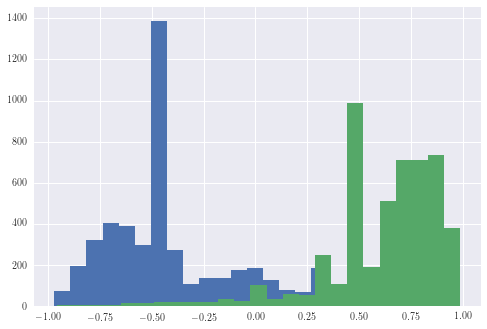

In [110]:
plt.hist([analyzer.polarity_scores(' '.join(x))['compound'] for x in negtweets], bins=25);
plt.hist([analyzer.polarity_scores(' '.join(x))['compound'] for x in postweets], bins=25);